In [104]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
from sklearn.metrics import r2_score

input_window = 24 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8
n_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Positional Encoding

In [105]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

# Transformer Class

In [106]:
class TransAm(nn.Module):
    def __init__(self,feature_size=256,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=16, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# InOut Sequence 

In [107]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))

# Get Data

In [108]:
def get_data(path):
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd

    data = pd.read_csv(path,index_col="Index")

    data = data[(data['Date'] < '2012-10-01 00:00:00')]
    data = data.dropna()


    
    data_energyConsumption = data["energyConsumption"]
    
    
    # looks like normalizing input values curtial for the model
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    energyConsumption = scaler.fit_transform(data_energyConsumption.to_numpy().reshape(-1, 1)).reshape(-1)

    sampels = int(len(data_energyConsumption) * train_size) # use a parameter to control training size
    train_data = energyConsumption[:sampels]
    test_data = energyConsumption[sampels:]


    train_sequence = create_inout_sequences( train_data,input_window ,output_window)
    test_data = create_inout_sequences(test_data,input_window,output_window)

    # shape with (block , sql_len , 2 )
    return train_sequence.to(device),test_data.to(device)

# Batch

In [109]:
def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

# Train

In [110]:
def train(train_data, model, optimizer, criterion, scheduler, epoch):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return model

# Helper

In [119]:
def plot_and_loss(eval_model, data_source,epoch,criterion):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    len(test_result)
    if (epoch % 5 == 0):
        pyplot.plot(test_result,color="red")
        pyplot.plot(truth[:500],color="blue")
        pyplot.plot(test_result-truth,color="green")
        pyplot.grid(True, which='both')
        pyplot.axhline(y=0, color='k')
        pyplot.savefig('output/transformer-epoch%d.png'%epoch)
        pyplot.close()
    return total_loss / i, r2_score(test_result, truth)


# predict the next n steps based on the input data 
def predict_future(eval_model, data_source,steps,input_window,real_data):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    
    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data,color="red")       
    pyplot.plot(real_data[:steps+ input_window],color="green", linestyle='dashed') 
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('output/transformer-future%d.png'%steps)
    pyplot.show()
    pyplot.close() 
        

def evaluate(eval_model, data_source,criterion):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

# DataAnalysis

       TemperatureC  Dew PointC  Humidity  Sea Level PressurehPa  \
Index                                                              
6570            NaN         NaN       NaN                    NaN   
6571           16.7         7.2      53.0                 1010.8   
6572            NaN         NaN       NaN                    NaN   
6573           13.9         9.4      74.0                 1011.4   
6574           11.7         9.4      86.0                 1011.2   

       VisibilityKm  WindDirDegrees  energyConsumption                 Date  
Index                                                                        
6570            NaN             NaN           27.75545  2012-09-30 19:00:00  
6571           16.1           240.0           27.33870  2012-09-30 20:00:00  
6572            NaN             NaN           26.33850  2012-09-30 21:00:00  
6573           16.1           220.0           26.17180  2012-09-30 22:00:00  
6574           16.1             0.0           26.33850 

C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


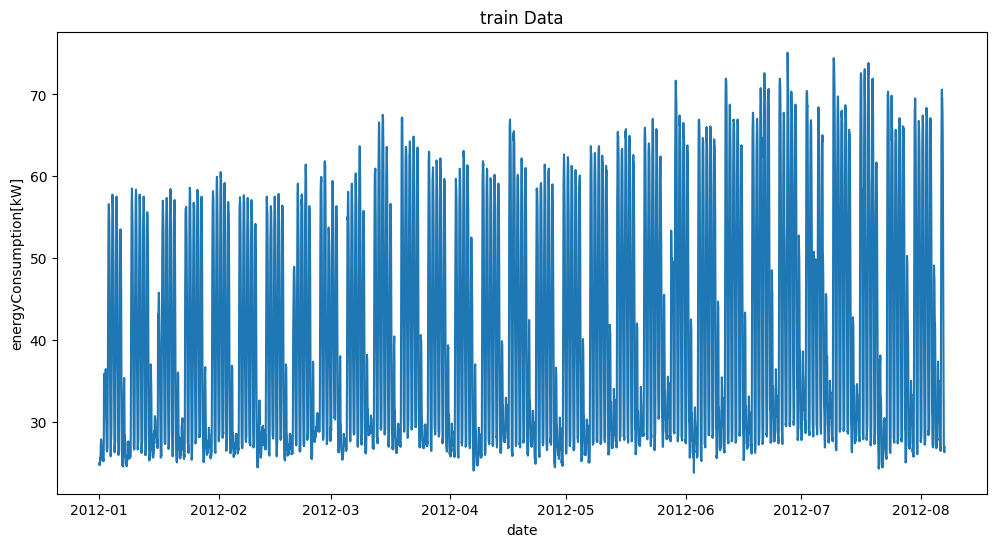

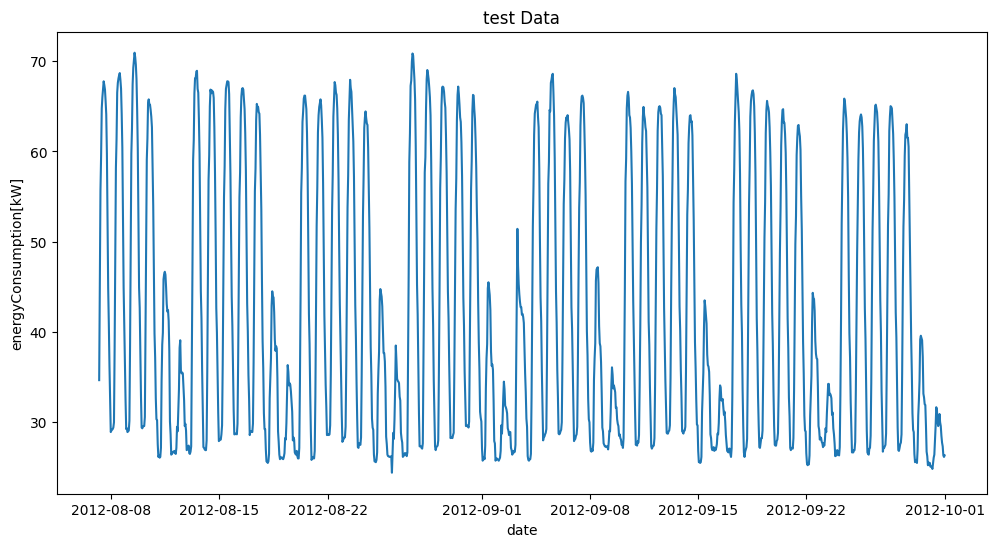

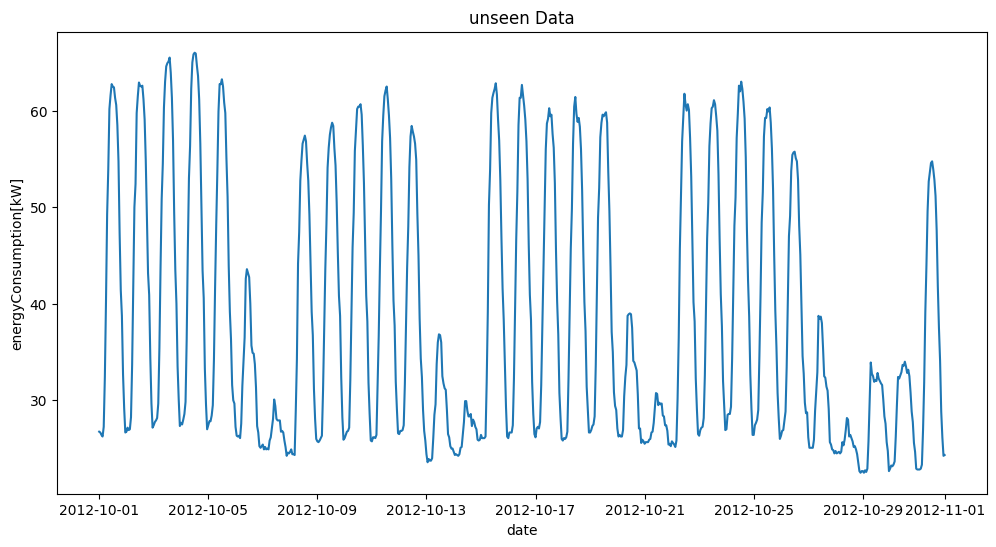

In [112]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("data/Office_Eddie.csv",index_col="Index")

unseenData = data[(data['Date'] >= "2012-10-01 00:00:00")]
unseenData["Date"] = pd.to_datetime(unseenData["Date"])
unseenEnergyConsumption = unseenData["energyConsumption"]
scaler = MinMaxScaler(feature_range=(-1, 1)) 
unseenEnergyConsumption = scaler.fit_transform(unseenEnergyConsumption.to_numpy().reshape(-1, 1)).reshape(-1)
data = data[(data['Date'] < '2012-10-01 00:00:00')]

sampels = int(len(data) * train_size) # use a parameter to control training size
print(data.tail())
energyConsumption = data["energyConsumption"]
date_time = pd.to_datetime(data["Date"])
pyplot.figure(figsize=(12,6))
pyplot.title("train Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(date_time[:sampels], energyConsumption[:sampels])

pyplot.figure(figsize=(12,6))
pyplot.title("test Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(date_time[sampels:], energyConsumption[sampels:])

pyplot.figure(figsize=(12,6))
pyplot.title("unseen Data")
pyplot.xlabel("date")
pyplot.ylabel("energyConsumption[kW]")
pyplot.plot(unseenData["Date"], unseenData["energyConsumption"])

# MainLoop

C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    93/  468 batches | lr 0.005000 | 47.70 ms | loss 3.25295 | ppl    25.87
| epoch   1 |   186/  468 batches | lr 0.005000 | 53.51 ms | loss 0.42144 | ppl     1.52
| epoch   1 |   279/  468 batches | lr 0.005000 | 50.88 ms | loss 0.37189 | ppl     1.45
| epoch   1 |   372/  468 batches | lr 0.005000 | 44.61 ms | loss 0.40336 | ppl     1.50
| epoch   1 |   465/  468 batches | lr 0.005000 | 43.61 ms | loss 0.40880 | ppl     1.51
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 24.76s | valid loss 0.36341 | valid ppl     1.44 | r2_score -12826218112.700
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   2 |    93/  468 batches | lr 0.004513 | 42.80 ms | loss 0.27471 | ppl     1.32
| epoch   2 |   186/  468 batches | lr 0.004513 | 41.46 ms | loss 0.25818 | ppl     1.29
| epoch   2 |   279/  468 batches | lr 0.004513 | 45.52 ms | loss 0.29505 | ppl     1.34
| epoch   2 |   372/  468 batches | lr 0.004513 | 45.72 ms | loss 0.36433 | ppl     1.44
| epoch   2 |   465/  468 batches | lr 0.004513 | 44.57 ms | loss 0.39702 | ppl     1.49
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 22.67s | valid loss 0.34633 | valid ppl     1.41 | r2_score -1100436932.445
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   3 |    93/  468 batches | lr 0.004287 | 47.09 ms | loss 0.26082 | ppl     1.30
| epoch   3 |   186/  468 batches | lr 0.004287 | 45.87 ms | loss 0.25611 | ppl     1.29
| epoch   3 |   279/  468 batches | lr 0.004287 | 45.84 ms | loss 0.28424 | ppl     1.33
| epoch   3 |   372/  468 batches | lr 0.004287 | 53.39 ms | loss 0.35027 | ppl     1.42
| epoch   3 |   465/  468 batches | lr 0.004287 | 54.09 ms | loss 0.39191 | ppl     1.48
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 25.41s | valid loss 0.34331 | valid ppl     1.41 | r2_score -54395805726.788
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   4 |    93/  468 batches | lr 0.004073 | 48.95 ms | loss 0.25630 | ppl     1.29
| epoch   4 |   186/  468 batches | lr 0.004073 | 49.23 ms | loss 0.25612 | ppl     1.29
| epoch   4 |   279/  468 batches | lr 0.004073 | 49.07 ms | loss 0.28653 | ppl     1.33
| epoch   4 |   372/  468 batches | lr 0.004073 | 48.42 ms | loss 0.35345 | ppl     1.42
| epoch   4 |   465/  468 batches | lr 0.004073 | 45.34 ms | loss 0.39247 | ppl     1.48
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 24.65s | valid loss 0.34228 | valid ppl     1.41 | r2_score -8680827874622.526
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   5 |    93/  468 batches | lr 0.003869 | 45.90 ms | loss 0.25518 | ppl     1.29
| epoch   5 |   186/  468 batches | lr 0.003869 | 44.94 ms | loss 0.25451 | ppl     1.29
| epoch   5 |   279/  468 batches | lr 0.003869 | 41.81 ms | loss 0.11400 | ppl     1.12
| epoch   5 |   372/  468 batches | lr 0.003869 | 40.38 ms | loss 0.05149 | ppl     1.05
| epoch   5 |   465/  468 batches | lr 0.003869 | 40.29 ms | loss 0.05157 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 22.45s | valid loss 0.05589 | valid ppl     1.06 | r2_score    0.873
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   6 |    93/  468 batches | lr 0.003675 | 40.85 ms | loss 0.03520 | ppl     1.04
| epoch   6 |   186/  468 batches | lr 0.003675 | 40.35 ms | loss 0.03736 | ppl     1.04
| epoch   6 |   279/  468 batches | lr 0.003675 | 40.14 ms | loss 0.04112 | ppl     1.04
| epoch   6 |   372/  468 batches | lr 0.003675 | 39.56 ms | loss 0.05016 | ppl     1.05
| epoch   6 |   465/  468 batches | lr 0.003675 | 39.60 ms | loss 0.04351 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 21.03s | valid loss 0.04349 | valid ppl     1.04 | r2_score    0.888
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   7 |    93/  468 batches | lr 0.003492 | 41.63 ms | loss 0.02757 | ppl     1.03
| epoch   7 |   186/  468 batches | lr 0.003492 | 40.06 ms | loss 0.02787 | ppl     1.03
| epoch   7 |   279/  468 batches | lr 0.003492 | 39.98 ms | loss 0.03116 | ppl     1.03
| epoch   7 |   372/  468 batches | lr 0.003492 | 39.96 ms | loss 0.04261 | ppl     1.04
| epoch   7 |   465/  468 batches | lr 0.003492 | 39.33 ms | loss 0.04477 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 21.14s | valid loss 0.04560 | valid ppl     1.05 | r2_score    0.894
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   8 |    93/  468 batches | lr 0.003317 | 40.16 ms | loss 0.02441 | ppl     1.02
| epoch   8 |   186/  468 batches | lr 0.003317 | 40.23 ms | loss 0.02588 | ppl     1.03
| epoch   8 |   279/  468 batches | lr 0.003317 | 39.48 ms | loss 0.02849 | ppl     1.03
| epoch   8 |   372/  468 batches | lr 0.003317 | 38.82 ms | loss 0.04102 | ppl     1.04
| epoch   8 |   465/  468 batches | lr 0.003317 | 40.30 ms | loss 0.05153 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 20.89s | valid loss 0.04730 | valid ppl     1.05 | r2_score    0.887
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   9 |    93/  468 batches | lr 0.003151 | 40.54 ms | loss 0.02384 | ppl     1.02
| epoch   9 |   186/  468 batches | lr 0.003151 | 40.01 ms | loss 0.02551 | ppl     1.03
| epoch   9 |   279/  468 batches | lr 0.003151 | 39.75 ms | loss 0.02814 | ppl     1.03
| epoch   9 |   372/  468 batches | lr 0.003151 | 39.35 ms | loss 0.03935 | ppl     1.04
| epoch   9 |   465/  468 batches | lr 0.003151 | 39.41 ms | loss 0.04483 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 20.93s | valid loss 0.04664 | valid ppl     1.05 | r2_score    0.882
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  10 |    93/  468 batches | lr 0.002994 | 40.99 ms | loss 0.02244 | ppl     1.02
| epoch  10 |   186/  468 batches | lr 0.002994 | 39.72 ms | loss 0.02352 | ppl     1.02
| epoch  10 |   279/  468 batches | lr 0.002994 | 39.78 ms | loss 0.02614 | ppl     1.03
| epoch  10 |   372/  468 batches | lr 0.002994 | 39.45 ms | loss 0.03743 | ppl     1.04
| epoch  10 |   465/  468 batches | lr 0.002994 | 39.90 ms | loss 0.04383 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 21.30s | valid loss 0.04335 | valid ppl     1.04 | r2_score    0.893
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  11 |    93/  468 batches | lr 0.002844 | 40.16 ms | loss 0.02143 | ppl     1.02
| epoch  11 |   186/  468 batches | lr 0.002844 | 40.25 ms | loss 0.02514 | ppl     1.03
| epoch  11 |   279/  468 batches | lr 0.002844 | 40.31 ms | loss 0.02571 | ppl     1.03
| epoch  11 |   372/  468 batches | lr 0.002844 | 39.17 ms | loss 0.03210 | ppl     1.03
| epoch  11 |   465/  468 batches | lr 0.002844 | 39.21 ms | loss 0.03888 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 20.97s | valid loss 0.04482 | valid ppl     1.05 | r2_score    0.870
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  12 |    93/  468 batches | lr 0.002702 | 39.81 ms | loss 0.02568 | ppl     1.03
| epoch  12 |   186/  468 batches | lr 0.002702 | 40.23 ms | loss 0.02489 | ppl     1.03
| epoch  12 |   279/  468 batches | lr 0.002702 | 39.42 ms | loss 0.02712 | ppl     1.03
| epoch  12 |   372/  468 batches | lr 0.002702 | 41.37 ms | loss 0.03492 | ppl     1.04
| epoch  12 |   465/  468 batches | lr 0.002702 | 40.48 ms | loss 0.03643 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 21.04s | valid loss 0.04308 | valid ppl     1.04 | r2_score    0.881
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  13 |    93/  468 batches | lr 0.002567 | 39.33 ms | loss 0.02401 | ppl     1.02
| epoch  13 |   186/  468 batches | lr 0.002567 | 40.38 ms | loss 0.02288 | ppl     1.02
| epoch  13 |   279/  468 batches | lr 0.002567 | 39.21 ms | loss 0.02549 | ppl     1.03
| epoch  13 |   372/  468 batches | lr 0.002567 | 39.08 ms | loss 0.03467 | ppl     1.04
| epoch  13 |   465/  468 batches | lr 0.002567 | 38.80 ms | loss 0.03523 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 20.62s | valid loss 0.04342 | valid ppl     1.04 | r2_score    0.868
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  14 |    93/  468 batches | lr 0.002438 | 40.21 ms | loss 0.02129 | ppl     1.02
| epoch  14 |   186/  468 batches | lr 0.002438 | 39.21 ms | loss 0.02175 | ppl     1.02
| epoch  14 |   279/  468 batches | lr 0.002438 | 38.66 ms | loss 0.02378 | ppl     1.02
| epoch  14 |   372/  468 batches | lr 0.002438 | 41.03 ms | loss 0.03263 | ppl     1.03
| epoch  14 |   465/  468 batches | lr 0.002438 | 39.88 ms | loss 0.04281 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 20.82s | valid loss 0.04165 | valid ppl     1.04 | r2_score    0.870
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  15 |    93/  468 batches | lr 0.002316 | 40.96 ms | loss 0.02172 | ppl     1.02
| epoch  15 |   186/  468 batches | lr 0.002316 | 40.00 ms | loss 0.02055 | ppl     1.02
| epoch  15 |   279/  468 batches | lr 0.002316 | 40.66 ms | loss 0.02311 | ppl     1.02
| epoch  15 |   372/  468 batches | lr 0.002316 | 39.67 ms | loss 0.03332 | ppl     1.03
| epoch  15 |   465/  468 batches | lr 0.002316 | 40.64 ms | loss 0.03767 | ppl     1.04
-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 21.29s | valid loss 0.04267 | valid ppl     1.04 | r2_score    0.894
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  16 |    93/  468 batches | lr 0.002201 | 40.50 ms | loss 0.02060 | ppl     1.02
| epoch  16 |   186/  468 batches | lr 0.002201 | 40.15 ms | loss 0.02014 | ppl     1.02
| epoch  16 |   279/  468 batches | lr 0.002201 | 39.75 ms | loss 0.02263 | ppl     1.02
| epoch  16 |   372/  468 batches | lr 0.002201 | 40.05 ms | loss 0.03010 | ppl     1.03
| epoch  16 |   465/  468 batches | lr 0.002201 | 39.66 ms | loss 0.03261 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 21.14s | valid loss 0.04120 | valid ppl     1.04 | r2_score    0.894
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  17 |    93/  468 batches | lr 0.002091 | 41.95 ms | loss 0.01789 | ppl     1.02
| epoch  17 |   186/  468 batches | lr 0.002091 | 41.45 ms | loss 0.01959 | ppl     1.02
| epoch  17 |   279/  468 batches | lr 0.002091 | 40.52 ms | loss 0.02163 | ppl     1.02
| epoch  17 |   372/  468 batches | lr 0.002091 | 40.33 ms | loss 0.02991 | ppl     1.03
| epoch  17 |   465/  468 batches | lr 0.002091 | 40.65 ms | loss 0.03283 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 21.33s | valid loss 0.04145 | valid ppl     1.04 | r2_score    0.888
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  18 |    93/  468 batches | lr 0.001986 | 41.01 ms | loss 0.02156 | ppl     1.02
| epoch  18 |   186/  468 batches | lr 0.001986 | 43.88 ms | loss 0.02017 | ppl     1.02
| epoch  18 |   279/  468 batches | lr 0.001986 | 44.47 ms | loss 0.02208 | ppl     1.02
| epoch  18 |   372/  468 batches | lr 0.001986 | 43.61 ms | loss 0.02905 | ppl     1.03
| epoch  18 |   465/  468 batches | lr 0.001986 | 43.41 ms | loss 0.03101 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 22.63s | valid loss 0.04646 | valid ppl     1.05 | r2_score    0.869
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  19 |    93/  468 batches | lr 0.001887 | 41.41 ms | loss 0.01906 | ppl     1.02
| epoch  19 |   186/  468 batches | lr 0.001887 | 43.21 ms | loss 0.01942 | ppl     1.02
| epoch  19 |   279/  468 batches | lr 0.001887 | 40.63 ms | loss 0.02085 | ppl     1.02
| epoch  19 |   372/  468 batches | lr 0.001887 | 39.09 ms | loss 0.03002 | ppl     1.03
| epoch  19 |   465/  468 batches | lr 0.001887 | 35.18 ms | loss 0.03249 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 20.71s | valid loss 0.04164 | valid ppl     1.04 | r2_score    0.876
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  20 |    93/  468 batches | lr 0.001792 | 36.73 ms | loss 0.01929 | ppl     1.02
| epoch  20 |   186/  468 batches | lr 0.001792 | 35.46 ms | loss 0.01896 | ppl     1.02
| epoch  20 |   279/  468 batches | lr 0.001792 | 35.81 ms | loss 0.02166 | ppl     1.02
| epoch  20 |   372/  468 batches | lr 0.001792 | 36.04 ms | loss 0.02908 | ppl     1.03
| epoch  20 |   465/  468 batches | lr 0.001792 | 35.61 ms | loss 0.03303 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 19.06s | valid loss 0.04436 | valid ppl     1.05 | r2_score    0.884
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  21 |    93/  468 batches | lr 0.001703 | 37.01 ms | loss 0.01810 | ppl     1.02
| epoch  21 |   186/  468 batches | lr 0.001703 | 37.08 ms | loss 0.01920 | ppl     1.02
| epoch  21 |   279/  468 batches | lr 0.001703 | 41.03 ms | loss 0.02070 | ppl     1.02
| epoch  21 |   372/  468 batches | lr 0.001703 | 41.21 ms | loss 0.02915 | ppl     1.03
| epoch  21 |   465/  468 batches | lr 0.001703 | 39.61 ms | loss 0.03349 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 20.48s | valid loss 0.04421 | valid ppl     1.05 | r2_score    0.881
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  22 |    93/  468 batches | lr 0.001618 | 47.61 ms | loss 0.01819 | ppl     1.02
| epoch  22 |   186/  468 batches | lr 0.001618 | 47.55 ms | loss 0.01868 | ppl     1.02
| epoch  22 |   279/  468 batches | lr 0.001618 | 46.34 ms | loss 0.02106 | ppl     1.02
| epoch  22 |   372/  468 batches | lr 0.001618 | 43.26 ms | loss 0.02873 | ppl     1.03
| epoch  22 |   465/  468 batches | lr 0.001618 | 38.31 ms | loss 0.03125 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 22.92s | valid loss 0.04617 | valid ppl     1.05 | r2_score    0.869
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  23 |    93/  468 batches | lr 0.001537 | 42.56 ms | loss 0.01774 | ppl     1.02
| epoch  23 |   186/  468 batches | lr 0.001537 | 45.08 ms | loss 0.01807 | ppl     1.02
| epoch  23 |   279/  468 batches | lr 0.001537 | 36.46 ms | loss 0.02111 | ppl     1.02
| epoch  23 |   372/  468 batches | lr 0.001537 | 36.09 ms | loss 0.02685 | ppl     1.03
| epoch  23 |   465/  468 batches | lr 0.001537 | 41.26 ms | loss 0.03110 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  23 | time: 21.37s | valid loss 0.04343 | valid ppl     1.04 | r2_score    0.884
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  24 |    93/  468 batches | lr 0.001460 | 43.06 ms | loss 0.01643 | ppl     1.02
| epoch  24 |   186/  468 batches | lr 0.001460 | 45.40 ms | loss 0.01789 | ppl     1.02
| epoch  24 |   279/  468 batches | lr 0.001460 | 44.43 ms | loss 0.02061 | ppl     1.02
| epoch  24 |   372/  468 batches | lr 0.001460 | 48.67 ms | loss 0.02809 | ppl     1.03
| epoch  24 |   465/  468 batches | lr 0.001460 | 47.21 ms | loss 0.03202 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 24.90s | valid loss 0.04121 | valid ppl     1.04 | r2_score    0.891
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  25 |    93/  468 batches | lr 0.001387 | 49.18 ms | loss 0.01689 | ppl     1.02
| epoch  25 |   186/  468 batches | lr 0.001387 | 49.43 ms | loss 0.01762 | ppl     1.02
| epoch  25 |   279/  468 batches | lr 0.001387 | 47.53 ms | loss 0.01993 | ppl     1.02
| epoch  25 |   372/  468 batches | lr 0.001387 | 49.63 ms | loss 0.02681 | ppl     1.03
| epoch  25 |   465/  468 batches | lr 0.001387 | 42.22 ms | loss 0.03021 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 25.33s | valid loss 0.04703 | valid ppl     1.05 | r2_score    0.839
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  26 |    93/  468 batches | lr 0.001318 | 43.66 ms | loss 0.01865 | ppl     1.02
| epoch  26 |   186/  468 batches | lr 0.001318 | 40.44 ms | loss 0.01789 | ppl     1.02
| epoch  26 |   279/  468 batches | lr 0.001318 | 46.16 ms | loss 0.02021 | ppl     1.02
| epoch  26 |   372/  468 batches | lr 0.001318 | 47.18 ms | loss 0.02609 | ppl     1.03
| epoch  26 |   465/  468 batches | lr 0.001318 | 41.87 ms | loss 0.02873 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  26 | time: 22.89s | valid loss 0.05138 | valid ppl     1.05 | r2_score    0.821
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  27 |    93/  468 batches | lr 0.001252 | 40.85 ms | loss 0.01707 | ppl     1.02
| epoch  27 |   186/  468 batches | lr 0.001252 | 44.84 ms | loss 0.01757 | ppl     1.02
| epoch  27 |   279/  468 batches | lr 0.001252 | 42.23 ms | loss 0.01994 | ppl     1.02
| epoch  27 |   372/  468 batches | lr 0.001252 | 47.17 ms | loss 0.02666 | ppl     1.03
| epoch  27 |   465/  468 batches | lr 0.001252 | 46.11 ms | loss 0.03018 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  27 | time: 23.17s | valid loss 0.04618 | valid ppl     1.05 | r2_score    0.864
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  28 |    93/  468 batches | lr 0.001189 | 44.28 ms | loss 0.01713 | ppl     1.02
| epoch  28 |   186/  468 batches | lr 0.001189 | 41.85 ms | loss 0.01726 | ppl     1.02
| epoch  28 |   279/  468 batches | lr 0.001189 | 40.54 ms | loss 0.01978 | ppl     1.02
| epoch  28 |   372/  468 batches | lr 0.001189 | 44.63 ms | loss 0.02641 | ppl     1.03
| epoch  28 |   465/  468 batches | lr 0.001189 | 44.77 ms | loss 0.02919 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  28 | time: 22.48s | valid loss 0.04481 | valid ppl     1.05 | r2_score    0.857
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  29 |    93/  468 batches | lr 0.001130 | 41.01 ms | loss 0.01677 | ppl     1.02
| epoch  29 |   186/  468 batches | lr 0.001130 | 45.60 ms | loss 0.01724 | ppl     1.02
| epoch  29 |   279/  468 batches | lr 0.001130 | 46.20 ms | loss 0.01956 | ppl     1.02
| epoch  29 |   372/  468 batches | lr 0.001130 | 41.89 ms | loss 0.02604 | ppl     1.03
| epoch  29 |   465/  468 batches | lr 0.001130 | 46.00 ms | loss 0.02874 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  29 | time: 22.99s | valid loss 0.04745 | valid ppl     1.05 | r2_score    0.838
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  30 |    93/  468 batches | lr 0.001073 | 40.78 ms | loss 0.01737 | ppl     1.02
| epoch  30 |   186/  468 batches | lr 0.001073 | 40.82 ms | loss 0.01701 | ppl     1.02
| epoch  30 |   279/  468 batches | lr 0.001073 | 46.82 ms | loss 0.01966 | ppl     1.02
| epoch  30 |   372/  468 batches | lr 0.001073 | 41.27 ms | loss 0.02602 | ppl     1.03
| epoch  30 |   465/  468 batches | lr 0.001073 | 40.05 ms | loss 0.02739 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 22.10s | valid loss 0.04861 | valid ppl     1.05 | r2_score    0.835
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  31 |    93/  468 batches | lr 0.001020 | 41.12 ms | loss 0.01646 | ppl     1.02
| epoch  31 |   186/  468 batches | lr 0.001020 | 40.03 ms | loss 0.01680 | ppl     1.02
| epoch  31 |   279/  468 batches | lr 0.001020 | 40.31 ms | loss 0.01944 | ppl     1.02
| epoch  31 |   372/  468 batches | lr 0.001020 | 40.78 ms | loss 0.02528 | ppl     1.03
| epoch  31 |   465/  468 batches | lr 0.001020 | 51.97 ms | loss 0.02701 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 23.22s | valid loss 0.04928 | valid ppl     1.05 | r2_score    0.836
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  32 |    93/  468 batches | lr 0.000969 | 48.80 ms | loss 0.01687 | ppl     1.02
| epoch  32 |   186/  468 batches | lr 0.000969 | 47.73 ms | loss 0.01655 | ppl     1.02
| epoch  32 |   279/  468 batches | lr 0.000969 | 42.34 ms | loss 0.01911 | ppl     1.02
| epoch  32 |   372/  468 batches | lr 0.000969 | 42.12 ms | loss 0.02540 | ppl     1.03
| epoch  32 |   465/  468 batches | lr 0.000969 | 42.40 ms | loss 0.02777 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  32 | time: 23.53s | valid loss 0.04750 | valid ppl     1.05 | r2_score    0.830
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  33 |    93/  468 batches | lr 0.000920 | 44.77 ms | loss 0.01708 | ppl     1.02
| epoch  33 |   186/  468 batches | lr 0.000920 | 41.84 ms | loss 0.01721 | ppl     1.02
| epoch  33 |   279/  468 batches | lr 0.000920 | 46.79 ms | loss 0.01920 | ppl     1.02
| epoch  33 |   372/  468 batches | lr 0.000920 | 46.73 ms | loss 0.02493 | ppl     1.03
| epoch  33 |   465/  468 batches | lr 0.000920 | 46.25 ms | loss 0.02726 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 23.81s | valid loss 0.05272 | valid ppl     1.05 | r2_score    0.831
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  34 |    93/  468 batches | lr 0.000874 | 44.90 ms | loss 0.01631 | ppl     1.02
| epoch  34 |   186/  468 batches | lr 0.000874 | 49.46 ms | loss 0.01625 | ppl     1.02
| epoch  34 |   279/  468 batches | lr 0.000874 | 47.22 ms | loss 0.01869 | ppl     1.02
| epoch  34 |   372/  468 batches | lr 0.000874 | 48.69 ms | loss 0.02472 | ppl     1.03
| epoch  34 |   465/  468 batches | lr 0.000874 | 50.88 ms | loss 0.02736 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 25.46s | valid loss 0.05117 | valid ppl     1.05 | r2_score    0.838
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  35 |    93/  468 batches | lr 0.000830 | 45.27 ms | loss 0.01603 | ppl     1.02
| epoch  35 |   186/  468 batches | lr 0.000830 | 49.01 ms | loss 0.01624 | ppl     1.02
| epoch  35 |   279/  468 batches | lr 0.000830 | 42.57 ms | loss 0.01846 | ppl     1.02
| epoch  35 |   372/  468 batches | lr 0.000830 | 42.62 ms | loss 0.02457 | ppl     1.02
| epoch  35 |   465/  468 batches | lr 0.000830 | 46.70 ms | loss 0.02746 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 24.24s | valid loss 0.04843 | valid ppl     1.05 | r2_score    0.847
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  36 |    93/  468 batches | lr 0.000789 | 43.10 ms | loss 0.01535 | ppl     1.02
| epoch  36 |   186/  468 batches | lr 0.000789 | 41.80 ms | loss 0.01573 | ppl     1.02
| epoch  36 |   279/  468 batches | lr 0.000789 | 41.30 ms | loss 0.01833 | ppl     1.02
| epoch  36 |   372/  468 batches | lr 0.000789 | 40.67 ms | loss 0.02461 | ppl     1.02
| epoch  36 |   465/  468 batches | lr 0.000789 | 40.53 ms | loss 0.02688 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 21.86s | valid loss 0.04705 | valid ppl     1.05 | r2_score    0.835
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  37 |    93/  468 batches | lr 0.000749 | 41.90 ms | loss 0.01605 | ppl     1.02
| epoch  37 |   186/  468 batches | lr 0.000749 | 41.40 ms | loss 0.01596 | ppl     1.02
| epoch  37 |   279/  468 batches | lr 0.000749 | 40.50 ms | loss 0.01836 | ppl     1.02
| epoch  37 |   372/  468 batches | lr 0.000749 | 41.14 ms | loss 0.02447 | ppl     1.02
| epoch  37 |   465/  468 batches | lr 0.000749 | 41.07 ms | loss 0.02700 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 21.48s | valid loss 0.05468 | valid ppl     1.06 | r2_score    0.817
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  38 |    93/  468 batches | lr 0.000712 | 41.25 ms | loss 0.01614 | ppl     1.02
| epoch  38 |   186/  468 batches | lr 0.000712 | 41.95 ms | loss 0.01580 | ppl     1.02
| epoch  38 |   279/  468 batches | lr 0.000712 | 40.58 ms | loss 0.01812 | ppl     1.02
| epoch  38 |   372/  468 batches | lr 0.000712 | 41.22 ms | loss 0.02476 | ppl     1.03
| epoch  38 |   465/  468 batches | lr 0.000712 | 39.67 ms | loss 0.02627 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 21.48s | valid loss 0.04748 | valid ppl     1.05 | r2_score    0.839
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  39 |    93/  468 batches | lr 0.000676 | 40.39 ms | loss 0.01591 | ppl     1.02
| epoch  39 |   186/  468 batches | lr 0.000676 | 40.42 ms | loss 0.01566 | ppl     1.02
| epoch  39 |   279/  468 batches | lr 0.000676 | 40.57 ms | loss 0.01792 | ppl     1.02
| epoch  39 |   372/  468 batches | lr 0.000676 | 41.16 ms | loss 0.02437 | ppl     1.02
| epoch  39 |   465/  468 batches | lr 0.000676 | 41.97 ms | loss 0.02631 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 21.36s | valid loss 0.04664 | valid ppl     1.05 | r2_score    0.850
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  40 |    93/  468 batches | lr 0.000643 | 41.00 ms | loss 0.01484 | ppl     1.01
| epoch  40 |   186/  468 batches | lr 0.000643 | 40.87 ms | loss 0.01541 | ppl     1.02
| epoch  40 |   279/  468 batches | lr 0.000643 | 39.40 ms | loss 0.01771 | ppl     1.02
| epoch  40 |   372/  468 batches | lr 0.000643 | 40.92 ms | loss 0.02413 | ppl     1.02
| epoch  40 |   465/  468 batches | lr 0.000643 | 40.37 ms | loss 0.02639 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 21.31s | valid loss 0.04845 | valid ppl     1.05 | r2_score    0.850
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  41 |    93/  468 batches | lr 0.000610 | 40.61 ms | loss 0.01563 | ppl     1.02
| epoch  41 |   186/  468 batches | lr 0.000610 | 39.93 ms | loss 0.01536 | ppl     1.02
| epoch  41 |   279/  468 batches | lr 0.000610 | 40.44 ms | loss 0.01737 | ppl     1.02
| epoch  41 |   372/  468 batches | lr 0.000610 | 41.01 ms | loss 0.02414 | ppl     1.02
| epoch  41 |   465/  468 batches | lr 0.000610 | 40.04 ms | loss 0.02580 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 21.13s | valid loss 0.04616 | valid ppl     1.05 | r2_score    0.852
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  42 |    93/  468 batches | lr 0.000580 | 41.70 ms | loss 0.01547 | ppl     1.02
| epoch  42 |   186/  468 batches | lr 0.000580 | 40.18 ms | loss 0.01525 | ppl     1.02
| epoch  42 |   279/  468 batches | lr 0.000580 | 40.81 ms | loss 0.01751 | ppl     1.02
| epoch  42 |   372/  468 batches | lr 0.000580 | 40.80 ms | loss 0.02379 | ppl     1.02
| epoch  42 |   465/  468 batches | lr 0.000580 | 40.66 ms | loss 0.02555 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  42 | time: 21.30s | valid loss 0.05006 | valid ppl     1.05 | r2_score    0.832
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  43 |    93/  468 batches | lr 0.000551 | 41.10 ms | loss 0.01572 | ppl     1.02
| epoch  43 |   186/  468 batches | lr 0.000551 | 40.86 ms | loss 0.01555 | ppl     1.02
| epoch  43 |   279/  468 batches | lr 0.000551 | 42.35 ms | loss 0.01756 | ppl     1.02
| epoch  43 |   372/  468 batches | lr 0.000551 | 40.29 ms | loss 0.02376 | ppl     1.02
| epoch  43 |   465/  468 batches | lr 0.000551 | 40.23 ms | loss 0.02565 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  43 | time: 21.45s | valid loss 0.04974 | valid ppl     1.05 | r2_score    0.833
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  44 |    93/  468 batches | lr 0.000523 | 41.07 ms | loss 0.01569 | ppl     1.02
| epoch  44 |   186/  468 batches | lr 0.000523 | 41.47 ms | loss 0.01520 | ppl     1.02
| epoch  44 |   279/  468 batches | lr 0.000523 | 40.56 ms | loss 0.01712 | ppl     1.02
| epoch  44 |   372/  468 batches | lr 0.000523 | 39.97 ms | loss 0.02358 | ppl     1.02
| epoch  44 |   465/  468 batches | lr 0.000523 | 40.02 ms | loss 0.02565 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 21.31s | valid loss 0.05153 | valid ppl     1.05 | r2_score    0.836
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  45 |    93/  468 batches | lr 0.000497 | 41.01 ms | loss 0.01528 | ppl     1.02
| epoch  45 |   186/  468 batches | lr 0.000497 | 40.60 ms | loss 0.01491 | ppl     1.02
| epoch  45 |   279/  468 batches | lr 0.000497 | 42.42 ms | loss 0.01709 | ppl     1.02
| epoch  45 |   372/  468 batches | lr 0.000497 | 39.79 ms | loss 0.02331 | ppl     1.02
| epoch  45 |   465/  468 batches | lr 0.000497 | 40.53 ms | loss 0.02538 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  45 | time: 21.50s | valid loss 0.04787 | valid ppl     1.05 | r2_score    0.841
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  46 |    93/  468 batches | lr 0.000472 | 41.88 ms | loss 0.01489 | ppl     1.02
| epoch  46 |   186/  468 batches | lr 0.000472 | 41.40 ms | loss 0.01495 | ppl     1.02
| epoch  46 |   279/  468 batches | lr 0.000472 | 40.84 ms | loss 0.01694 | ppl     1.02
| epoch  46 |   372/  468 batches | lr 0.000472 | 40.11 ms | loss 0.02291 | ppl     1.02
| epoch  46 |   465/  468 batches | lr 0.000472 | 39.87 ms | loss 0.02495 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  46 | time: 21.36s | valid loss 0.04861 | valid ppl     1.05 | r2_score    0.843
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  47 |    93/  468 batches | lr 0.000449 | 40.34 ms | loss 0.01502 | ppl     1.02
| epoch  47 |   186/  468 batches | lr 0.000449 | 41.66 ms | loss 0.01531 | ppl     1.02
| epoch  47 |   279/  468 batches | lr 0.000449 | 40.35 ms | loss 0.01674 | ppl     1.02
| epoch  47 |   372/  468 batches | lr 0.000449 | 40.40 ms | loss 0.02333 | ppl     1.02
| epoch  47 |   465/  468 batches | lr 0.000449 | 40.54 ms | loss 0.02492 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  47 | time: 22.42s | valid loss 0.05077 | valid ppl     1.05 | r2_score    0.848
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  48 |    93/  468 batches | lr 0.000426 | 48.67 ms | loss 0.01521 | ppl     1.02
| epoch  48 |   186/  468 batches | lr 0.000426 | 43.85 ms | loss 0.01472 | ppl     1.01
| epoch  48 |   279/  468 batches | lr 0.000426 | 43.21 ms | loss 0.01645 | ppl     1.02
| epoch  48 |   372/  468 batches | lr 0.000426 | 43.28 ms | loss 0.02292 | ppl     1.02
| epoch  48 |   465/  468 batches | lr 0.000426 | 42.41 ms | loss 0.02472 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 23.15s | valid loss 0.05155 | valid ppl     1.05 | r2_score    0.841
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  49 |    93/  468 batches | lr 0.000405 | 43.84 ms | loss 0.01458 | ppl     1.01
| epoch  49 |   186/  468 batches | lr 0.000405 | 44.49 ms | loss 0.01478 | ppl     1.01
| epoch  49 |   279/  468 batches | lr 0.000405 | 45.69 ms | loss 0.01661 | ppl     1.02
| epoch  49 |   372/  468 batches | lr 0.000405 | 39.82 ms | loss 0.02271 | ppl     1.02
| epoch  49 |   465/  468 batches | lr 0.000405 | 40.63 ms | loss 0.02507 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  49 | time: 22.29s | valid loss 0.05074 | valid ppl     1.05 | r2_score    0.840
-----------------------------------------------------------------------------------------


C:\Users\leitner\AppData\Roaming\Python\Python37\site-packages\torch\optim\lr_scheduler.py:382: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  50 |    93/  468 batches | lr 0.000385 | 41.58 ms | loss 0.01503 | ppl     1.02
| epoch  50 |   186/  468 batches | lr 0.000385 | 41.12 ms | loss 0.01468 | ppl     1.01
| epoch  50 |   279/  468 batches | lr 0.000385 | 44.02 ms | loss 0.01665 | ppl     1.02
| epoch  50 |   372/  468 batches | lr 0.000385 | 42.55 ms | loss 0.02267 | ppl     1.02
| epoch  50 |   465/  468 batches | lr 0.000385 | 43.56 ms | loss 0.02474 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 22.41s | valid loss 0.05131 | valid ppl     1.05 | r2_score    0.828
-----------------------------------------------------------------------------------------


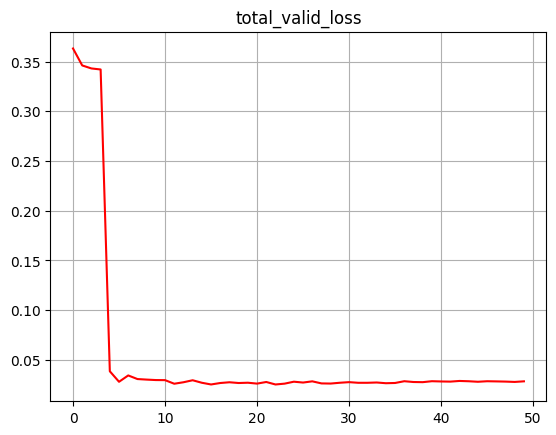

In [113]:
train_data, val_data = get_data("data/Office_Eddie.csv")
model = TransAm(num_layers=n_layers).to(device)

criterion = nn.MSELoss()
lr = 0.005 
loss = []
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 50 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    model = train(train_data, model, optimizer,criterion, scheduler, epoch)
    val_loss = evaluate(model, val_data ,criterion)
    loss.append(val_loss)
    val_loss, r2Score = plot_and_loss(model, val_data,epoch,criterion)

   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f} | r2_score {:8.3f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss), r2Score))
    print('-' * 89)


    scheduler.step() 
pyplot.plot(loss,color="red")          
pyplot.grid(True, which='both')
pyplot.title("total_valid_loss")
pyplot.savefig('output/total_valid_loss_num_layers{}.png'.format(n_layers))
pyplot.show()
torch.save(model, "model/savedModel_after_{}_epochs_num_layers{}.pth".format(epochs,n_layers))


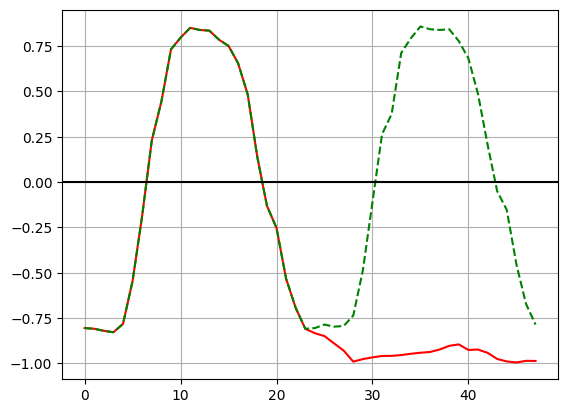

In [120]:
model = torch.load("model/savedModel_after_50_epochs_num_layers1.pth")
model.eval()
unseenEnergyConsumption_seq = create_inout_sequences(unseenEnergyConsumption,input_window,output_window)
predict_future(model, unseenEnergyConsumption_seq,24,24,unseenEnergyConsumption)

In [78]:
unseenEnergyConsumption[24:25]

array([-0.80459699])